<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
#подключим библиотеки
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
\
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle

from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#Посмотрим на нечисловые данные
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [4]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [5]:
data['Surname'].nunique()

2932

not numeric type Surname
not numeric type Geography
not numeric type Gender


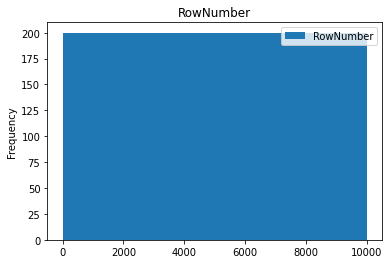

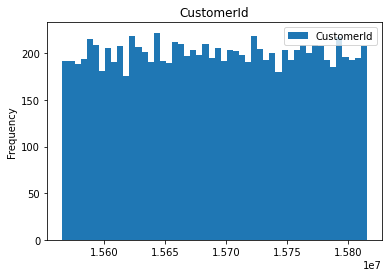

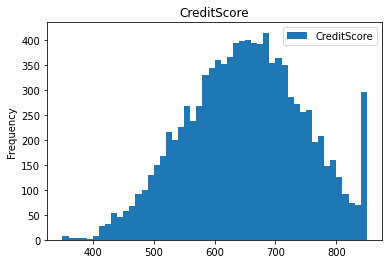

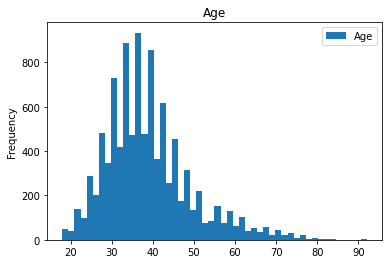

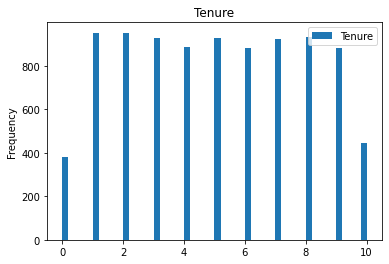

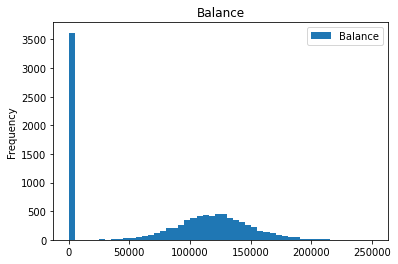

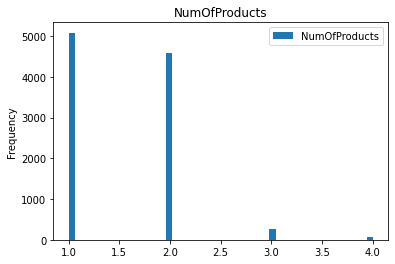

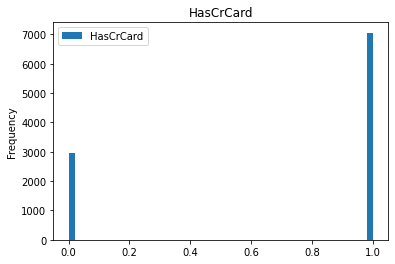

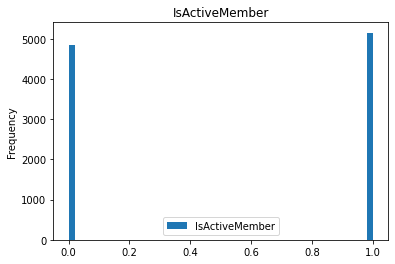

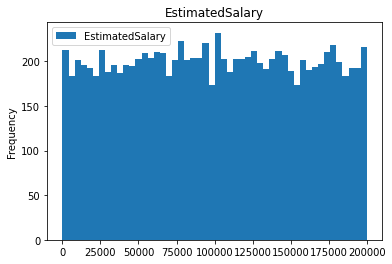

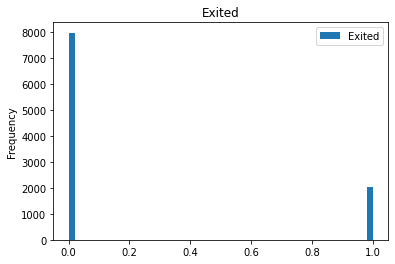

In [6]:
# Посмотрим на распределение числовых данных
for i in data:
    try:
        data.plot(y = i,title = i,kind = 'hist', bins = 50)
    except:
        print('not numeric type',i)

In [7]:
#Удалим столбцы, не участвующие в анализе, и проверим дублирование
data = data.drop(['RowNumber','CustomerId','Surname'],axis = 1)
data.duplicated().sum()

0

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

Качество данных неплохое: дублирования нет, есть пропуски в сроке взаимодействия клиента с банком. Заменим пустые значения единым "100500", чтобы сработало кодирование.

Нужно будет кодировать пол и географию.

Распределения данных не вызывают вопросов.

## Исследование задачи

In [8]:
data_ohe = pd.get_dummies(data,columns=['Tenure'], drop_first=False)
data_ohe = pd.get_dummies(data_ohe,columns=['Gender','Geography'], drop_first=True)
data_ohe.head()

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_0.0,Tenure_1.0,...,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,0.00,1,1,1,101348.88,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,608,41,83807.86,1,0,1,112542.58,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,502,42,159660.80,3,1,0,113931.57,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,699,39,0.00,2,0,0,93826.63,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,850,43,125510.82,1,1,1,79084.10,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Ок, кодирование свершилось. Все данные - числа с плавающей точкой.
Переходим к моделированию. 

In [9]:
features = data_ohe.drop(['Exited'],axis = 1)
target = data_ohe['Exited']


features_valid, features_train, target_valid, target_train = train_test_split(features, target, test_size = 0.8, random_state = 12345,stratify = target)
features_test, features_train, target_test, target_train = train_test_split(features_train, target_train, test_size = 0.75, random_state = 12345,stratify = target_train)


print(features.shape)
print(features_valid.shape)
print(features_train.shape)

print(target.shape)
print(target_valid.shape)
print(target_train.shape)

(10000, 21)
(2000, 21)
(6000, 21)
(10000,)
(2000,)
(6000,)


In [10]:
#Протестируем на модели логистической регрессии
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.13
auc-roc is 0.68


In [11]:
#Протестируем на модели деревьев решений
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.51
auc-roc is 0.69


In [12]:
#Протестируем на модели RandomForest
model = RandomForestClassifier(random_state=12345)
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.55
auc-roc is 0.85


До целевого значения F1-меры - 0.59 - не дотягивает результат ни у одной модели :(

## Борьба с дисбалансом

In [13]:
#Посмотрим на дисбаланс
data_ohe['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [14]:
#Добавим в модель аргумент взвешивания классов
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.49
auc-roc is 0.76


In [15]:
#Проверим взвешивание классов на модели деревьев решений
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.49
auc-roc is 0.68


In [16]:
#Проверим взвешивание классов на модели RandomForest
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train,target_train)
predictions_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.53
auc-roc is 0.85


Взвешивание классов не дало нужного эффекта на F1. Жаль
Интересно, что взвешивание для Random Forest ухудшило результат.

In [17]:
#Увеличим выборку
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [18]:
#Уменьшим выборку
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

In [19]:
#Протестируем модель логистической регрессии на увеличенной выборке
model = LogisticRegression(solver='liblinear',random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.53
auc-roc is 0.72


In [20]:
#Протестируем модель логистической регрессии на уменьшенной выборке
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.53
auc-roc is 0.72


Модель логистической регрессии не дала целевой результат ни на увеличенной, ни на уменьшенной выборке.

In [21]:
#Протестируем модель дерева решений на увеличенной выборке
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.53
auc-roc is 0.69


In [22]:
#Протестируем модель дерева решений на уменьшенной выборке
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.53
auc-roc is 0.7


Модель дерева решений не дала целевой результат ни на увеличенной, ни на уменьшенной выборке.

In [23]:
#Протестируем модель random forest на увеличенной выборке
model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.53
auc-roc is 0.85


In [24]:
#Протестируем модель random forest на уменьшенной выборке
model = RandomForestClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("f1 is",round(f1_score(target_valid, predictions_valid),2))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc-roc is",round(auc_roc,2))

f1 is 0.53
auc-roc is 0.85


Модель random forest не дала целевой результат ни на увеличенной, ни на уменьшенной выборке.

Максимальное значение f1-меры -0,58. Пока что это лучший результат.
Поэкспериментируем с гиперпараметрами модели

In [25]:
%time

best_res = 0
best_depth = 0
best_est = 0

for estimator in range(10, 100, 10):
    for depth in range(1, 20, 1):
        model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        if f1_score(target_valid, predicted_valid)>best_res:
            best_res = f1_score(target_valid, predicted_valid)
            best_depth = depth
            best_est = estimator
        

print(best_res)
print(best_depth)
print(best_est)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
0.6387176325524044
11
60


## Тестирование модели

Ок, целевое значение получено на модели RandomForestClassifier c 60 деревьями глубиной до 11.
Проверим на тестовой выборке.

In [26]:
model = RandomForestClassifier(n_estimators=60, max_depth=11, random_state=12345)
model.fit(features_upsampled, target_upsampled)

print("f1_test:", round(f1_score(target_test, model.predict(features_test)),2))
print("f1_valid:", round(f1_score(target_valid, model.predict(features_valid)),2))
print("f1_train:", round(f1_score(target_train, model.predict(features_train)),2))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("auc-roc is",round(auc_roc,2))

print(confusion_matrix(target_test,model.predict(features_test)))

f1_test: 0.65
f1_valid: 0.64
f1_train: 0.82
auc-roc is 0.88
[[1444  148]
 [ 141  267]]


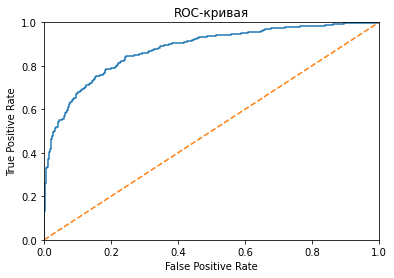

In [27]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

Модель верно распознает 86% клиентов.

Но не отловила 35% оттекающих клиентов - плохо.

Расходы на удержание клиентов, которые на самом деле не собирались оттекать, составят 55% от расходов на true positive clients -  тоже негативный фактор. 

14% бюджета, направленного на удержание, может быть потрачено впустую - нужно учитывать при планировании коммуникационной компании. 

Для удержания клиента обычно нужно продать новый продукт. Доходы от проданных продуктов должы покрыть расходы на коммуникацию и удержание - важно учесть при планировании продаж.